In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import math

# Adjust the path for c2qa and bosonic-qiskit modules
module_path = os.path.abspath(os.path.join('..', '..', '..'))  # Moves three directories up
if module_path not in sys.path:
    sys.path.append(module_path)

# Add the `playground` directory to the Python path
playground_path = Path.cwd().parent.parent  # Move two levels up to `playground`
if str(playground_path) not in sys.path:
    sys.path.append(str(playground_path))


# Qiskit and related imports
import qiskit
from qiskit.quantum_info import state_fidelity, Statevector, SparsePauliOp, Operator
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter, SuzukiTrotter

# Project-specific imports
import c2qa
import c2qa.util as util
from bosonic_operator_costs.all_qubit_utils import (
    create_annihilation_operator,
    create_creation_operator
)

A notebook to understand/work through Algorithm 1 of appendix F [here](https://arxiv.org/abs/2407.10381).

We will start with minimal examples of $n_{max} = 3$, hence requiring a register of $n = 2$ qubits to represent $|\psi\rangle = \alpha |00\rangle + \beta|01\rangle + \gamma |10\rangle + \delta|11\rangle$ using a Fock binary encoding.

We first subdivide the Hamiltonian into $H = H_{even} + H_{odd}$.

$$
H_{even} + H_{odd} = [0] \oplus 
\bigoplus_{j=1}^{\infty} 
\begin{bmatrix}
0 & \sqrt{2j} \\
\sqrt{2j} & 0
\end{bmatrix} \oplus [0]
+ 
\bigoplus_{j=0}^{\infty} 
\begin{bmatrix}
0 & \sqrt{2j+1} \\
\sqrt{2j+1} & 0
\end{bmatrix}
$$


In [2]:
from scipy.linalg import block_diag

def define_even_odd_hamiltonians(n_max):
    """
    Constructs H_even and H_odd Hamiltonians as block diagonal matrices (eq F9).
    """
    
    # Construct H_even
    blocks_even = [np.array([[0]])]  # Start with a [0] block
    j_max_even = n_max // 2  # Maximum j for even
    
    for j in range(1, j_max_even + 1):
        if 2 * j <= n_max:
            sqrt_2j = np.sqrt(2 * j)
            block = np.array([[0, sqrt_2j],
                              [sqrt_2j, 0]])
            blocks_even.append(block)
    
    blocks_even.append(np.array([[0]]))  # End with a [0] block
    H_even = block_diag(*blocks_even)
    
    # Construct H_odd
    blocks_odd = []
    j_max_odd = (n_max - 1) // 2  # Maximum j for odd
    
    for j in range(0, j_max_odd + 1):
        if 2 * j + 1 <= n_max:
            sqrt_2j1 = np.sqrt(2 * j + 1)
            block = np.array([[0, sqrt_2j1],
                              [sqrt_2j1, 0]])
            blocks_odd.append(block)
    
    if blocks_odd:
        H_odd = block_diag(*blocks_odd)
    else:
        H_odd = np.array([[0]])  # If no blocks, return a single [0] block
    
    return H_even, H_odd

n_max = 3
H_even, H_odd = define_even_odd_hamiltonians(n_max)

print("H_even:")
print(H_even)
print("\nH_odd:")
print(H_odd)

H_even:
[[0.         0.         0.         0.        ]
 [0.         0.         1.41421356 0.        ]
 [0.         1.41421356 0.         0.        ]
 [0.         0.         0.         0.        ]]

H_odd:
[[0.         1.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.         0.         0.         1.73205081]
 [0.         0.         1.73205081 0.        ]]


Next, we need a Trotter decomposition of the form $$V(\alpha) = \prod_{j = 1}^{N_{exp}/2} e^{-i\alpha H_{odd}\tau_{2j-1}} e^{-i\alpha H_{even}\tau_{2j}}.$$

### Comparison
##### Scaling for pure Trotterization (1st order)


- **Non-Clifford Rotations ($N_{\text{rotations}}$):**  
  $$
  N_{\text{rotations}} = \frac{1}{2} \log_2(n_{\max} + 1) (n_{\max} + 1)
  $$
  
- **CNOT Count ($N_{\text{CNOT, Trot}}$):**  
  $$
  N_{\text{CNOT, Trot}} = \log_2(n_{\max} + 1)\Bigl(\log_2(n_{\max} + 1)-1\Bigr)\,(n_{\max} + 1)
  $$

- **Qubit Count ($N_{\text{qubits, Trot}}$):**  
  $$
  N_{\text{qubits, Trot}} = \log_2(n_{\max} + 1)
  $$

##### **2407.10381 Method (Equations F34 and F36 with Newton Iterations $ m $)**

- **CNOT Count ($N_{\text{CNOT, 2407}}$):**  
  $$
  N_{\text{CNOT, 2407}} = (270m + 126) \cdot (\log_2(n_{\max} + 1))^2 + (144 + 228m) \cdot \log_2(n_{\max} + 1) - 12m - 22
  $$

- **Qubit Count ($N_{\text{qubits, 2407}}$):**  
  $$
  N_{\text{qubits, 2407}} = 2 \cdot \log_2(n_{\max} + 1) \cdot (m + 5) + 3 \cdot \log_2(n_{\max} + 1)
  $$



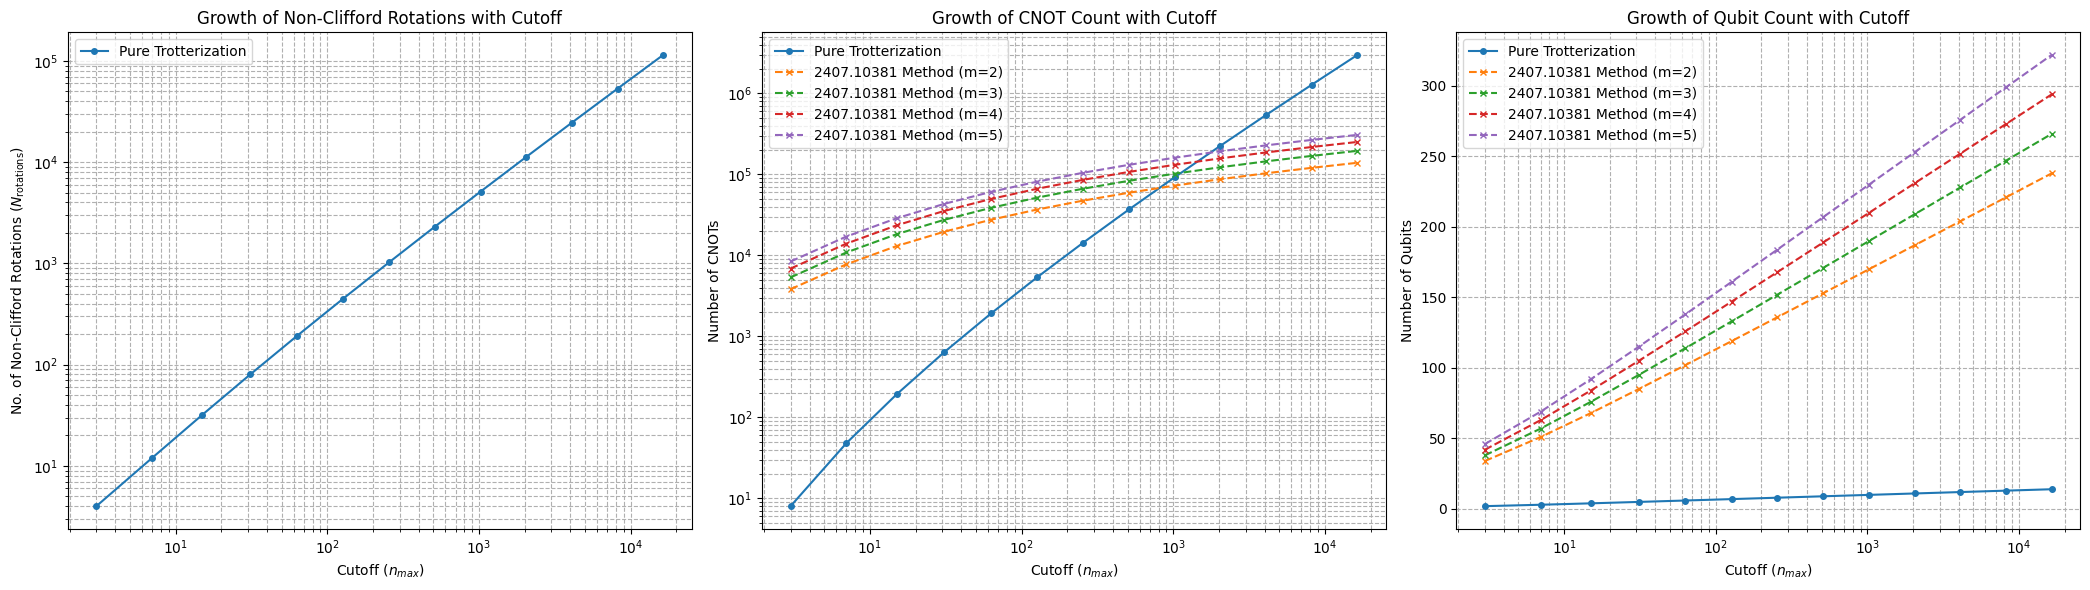

In [3]:
import math
import matplotlib.pyplot as plt

# Define qubit counts and compute cutoff values
qubit_counts = range(2, 15)
cutoff_values = [2**q - 1 for q in qubit_counts]
log2_n_max_plus_1 = [math.log2(cutoff + 1) for cutoff in cutoff_values]

# Compute Non-Clifford Rotations
N_rotations_values = [0.5 * (cutoff + 1) * q for cutoff, q in zip(cutoff_values, log2_n_max_plus_1)]

# Compute CNOTs for Pure Trotterization
cnots_trot_values = [q * (q - 1) * (cutoff + 1) for q, cutoff in zip(log2_n_max_plus_1, cutoff_values)]

# Define 2407 method parameters
m_values = [2, 3, 4, 5]
cnots_2407_dict, qubits_2407_dict = {}, {}

for m in m_values:
    cnots_2407_dict[m] = [(270 * m + 126) * (q ** 2) + (144 + 228 * m) * q - 12 * m - 22 for q in log2_n_max_plus_1]
    qubits_2407_dict[m] = [2 * q * (m + 5) + 3 * q for q in log2_n_max_plus_1]

# suplots
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Non-Clifford Rotations with Cutoff
axes[0].plot(cutoff_values, N_rotations_values, 'o-', markersize=4, label='Pure Trotterization')
axes[0].set(xlabel="Cutoff ($n_{max}$)", ylabel="No. of Non-Clifford Rotations ($N_{\\text{rotations}}$)",
             title="Growth of Non-Clifford Rotations with Cutoff", xscale='log', yscale='log')
axes[0].grid(True, which="both", linestyle="--")
axes[0].legend()

# CNOT Count with Cutoff
axes[1].plot(cutoff_values, cnots_trot_values, 'o-', markersize=4, label='Pure Trotterization')
for m in m_values:
    axes[1].plot(cutoff_values, cnots_2407_dict[m], 'x--', markersize=4, label=f'2407.10381 Method (m={m})')
axes[1].set(xlabel="Cutoff ($n_{max}$)", ylabel="Number of CNOTs", title="Growth of CNOT Count with Cutoff",
             xscale='log', yscale='log')
axes[1].grid(True, which="both", linestyle="--")
axes[1].legend()

# Qubit Count with Cutoff
axes[2].plot(cutoff_values, log2_n_max_plus_1, 'o-', markersize=4, label='Pure Trotterization')
for m in m_values:
    axes[2].plot(cutoff_values, qubits_2407_dict[m], 'x--', markersize=4, label=f'2407.10381 Method (m={m})')
axes[2].set(xlabel="Cutoff ($n_{max}$)", ylabel="Number of Qubits", title="Growth of Qubit Count with Cutoff",
             xscale='log', yscale='linear')
axes[2].grid(True, which="both", linestyle="--")
axes[2].legend()

plt.tight_layout()
plt.show()
